In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(1, '../domino/libs')
sys.path.insert(1, '../domino')
sys.path.insert(1, '/home/earendil/Documents/MyLib')

style.use('/home/earendil/Documents/MyLib/big_plt_style.mplstyle')

import pandas as pd

from libs.utilities import domino_mysql_server, read_mysql

In [7]:
model_version = '1.9'
scenario_id = -20
n_iter = 0

In [8]:
# Get model output
with domino_mysql_server(profile='remote_direct') as connection:
    query = "SELECT * FROM output_flights where model_version='" + model_version +\
            "' AND scenario_id=" + str(scenario_id) + " AND n_iter=" + str(n_iter)
    df = read_mysql(query=query, engine=connection['engine'])
    
    #query = """SELECT nid, flight_id, flt_num, f.ifps_id, callsign, airline, airline_type, origin, destination, sobt, sibt, aircraft_type, mtow, registration, max_seats, aobt, iobt, cobt, eobt
    #    FROM domino_environment.flight_schedule AS fs
    #    JOIN ddr_1409_nest.flight AS f ON fs.ifps_id=f.ifps_id
    #    """

    query = """SELECT
            #month(f.eobt) as month,
            #day(f.eobt) as day,
            #f.ao as airline,
            ddr.ifps_id,
            f.callsign as flight_number,
            f.registration as tail_number,
            f.origin as origin_airport,
            case ahg_origin.taxi_time
                when null then 10
                when 0 then 10
                else ahg_origin.taxi_time
            end as taxi_out,
            f.destination as destination_airport,
            case ahg_destination.taxi_time
                when null then 10
                when 0 then 10
                else ahg_destination.taxi_time
            end as taxi_in,
            f.sobt as sobt,
            ddr.aobt as aobt,
            takeoff.time_over as take_off_time,
            takeoff_sch.time_over as take_off_time_sch,
            f.sibt as sibt,
            landing.time_over as landing_time,
            landing_sch.time_over as landing_time_sch,
            case landing.time_over
                when null then null
                else if(ahg_destination.taxi_time is null, landing.time_over + INTERVAL 10 MINUTE,
                        if (ahg_destination.taxi_time=0, landing.time_over + INTERVAL 10 MINUTE,
                            landing.time_over + INTERVAL ahg_destination.taxi_time MINUTE))
            end as aibt,
            if(ddr.aobt is null,1,0) as cancelled
            from domino_environment.flight_schedule AS f
            join ddr_1409.flight ddr on ddr.ifps_id=f.ifps_id
            left join ddr_1409.airport ddr_origin on ddr_origin.icao_id=f.origin
            left join ddr_1409.airport_has_geopoint ahg_origin on ahg_origin.airport_id=ddr_origin.id
            left join ddr_1409.airport ddr_destination on ddr_destination.icao_id=f.destination
            left join ddr_1409.airport_has_geopoint ahg_destination on ahg_destination.airport_id=ddr_destination.id
            left join (
                select t.flight_id, thg.time_over
                from ddr_1409.trajectory_has_geopoint thg
                join ddr_1409.trajectory t on t.id=thg.trajectory_id
                where thg.`order`=1 and t.type="ctfm") as takeoff on takeoff.flight_id=ddr.id
            left join (
                select t.flight_id, thg.time_over
                from ddr_1409.trajectory_has_geopoint thg
                join ddr_1409.trajectory t on t.id=thg.trajectory_id
                where thg.`order`=1 and t.type="ftfm") as takeoff_sch on takeoff_sch.flight_id=ddr.id
            left join (
                select landing_order.flight_id, thg.time_over
                from ddr_1409.trajectory_has_geopoint thg
                join (
                    select t.flight_id, thg.trajectory_id, max(thg.`order`) as m_order
                    from ddr_1409.trajectory t
                    join ddr_1409.trajectory_has_geopoint thg on t.id=thg.trajectory_id
                    where t.type="ctfm"
                    group by thg.trajectory_id) as landing_order on landing_order.trajectory_id=thg.trajectory_id and landing_order.m_order=thg.`order`
                    ) as landing on landing.flight_id=ddr.id
            left join (
                select landing_order.flight_id, thg.time_over
                from ddr_1409.trajectory_has_geopoint thg
                join (
                    select t.flight_id, thg.trajectory_id, max(thg.`order`) as m_order
                    from ddr_1409.trajectory t
                    join ddr_1409.trajectory_has_geopoint thg on t.id=thg.trajectory_id
                    where t.type="ftfm"
                    group by thg.trajectory_id) as landing_order on landing_order.trajectory_id=thg.trajectory_id and landing_order.m_order=thg.`order`
                    ) as landing_sch on landing_sch.flight_id=ddr.id;"""
    df_hist = read_mysql(query=query, engine=connection['engine'])

DB connection to 127.0.0.1 with ssh tunneling through archdb.fst.westminster.ac.uk


In [20]:
df['departure_delay'] = (df['aobt']-df['sobt']).dt.total_seconds()/60.
df['arrival_delay'] = (df['aibt']-df['sibt']).dt.total_seconds()/60.
df['scheduled_G2G_time'] = (df['sibt']-df['sobt']).dt.total_seconds()/60.
df['actual_G2G_time'] = (df['aibt']-df['aobt']).dt.total_seconds()/60.
df['travelling_time_diff'] = ((df['aibt']-df['aobt']) - (df['sibt']-df['sobt'])).dt.total_seconds()/60.
df['scheduled_flying_time'] = df['m1_fp_time_min']
df['actual_flying_time'] = df['m3_fp_time_min']

df_hist['departure_delay'] = (df_hist['aobt']-df_hist['sobt']).dt.total_seconds()/60.
df_hist['arrival_delay'] = (df_hist['aibt']-df_hist['sibt']).dt.total_seconds()/60.
df_hist['scheduled_G2G_time'] = (df_hist['sibt']-df_hist['sobt']).dt.total_seconds()/60.
df_hist['actual_G2G_time'] = (df_hist['aibt']-df_hist['aobt']).dt.total_seconds()/60.
df_hist['travelling_time_diff'] = ((df_hist['aibt']-df_hist['aobt']) - (df_hist['sibt']-df_hist['sobt'])).dt.total_seconds()/60.
df_hist['scheduled_flying_time'] = (df_hist['landing_time_sch'] - df_hist['take_off_time_sch']).dt.total_seconds()/60.
df_hist['actual_flying_time'] = (df_hist['landing_time'] - df_hist['take_off_time']).dt.total_seconds()/60.
df_hist['taxi_out_traj'] = (df_hist['take_off_time'] - df_hist['aobt']).dt.total_seconds()/60.
df_hist['taxi_in_traj'] = (df_hist['aibt'] - df_hist['landing_time']).dt.total_seconds()/60.
#df_hist['arrival_delay'] = (df_hist['aibt']-df_hist['sibt']).dt.total_seconds()/60.

# Average values

In [21]:
print ('Number of flights:', len(df), len(df_hist))

Number of flights: 27261 27261


In [22]:
print ('First values are from model, second ones are from historical data')
print ('Average departure delay:', df['departure_delay'].mean(), df_hist['departure_delay'].mean())
print ('Average arrival delay:', df['arrival_delay'].mean(), df_hist['arrival_delay'].mean())
print ('Average scheduled G2G time:', df['scheduled_G2G_time'].mean(), df_hist['scheduled_G2G_time'].mean())
print ('Average actual G2G time:', df['actual_G2G_time'].mean(), df_hist['actual_G2G_time'].mean())
print ('Average scheduled flying time:', df['scheduled_flying_time'].mean(), df_hist['scheduled_flying_time'].mean())
print ('Average actual flying time:', df['actual_flying_time'].mean(), df_hist['actual_flying_time'].mean())
print ('Average actual taxi-out time:', df['axot'].mean(), df_hist['taxi_out'].mean())
print ('Average actual taxi-out time:', df['axot'].mean(), df_hist['taxi_out_traj'].mean())
print ('Average actual taxi-in time:', df['axit'].mean(), df_hist['taxi_in'].mean())
print ('Average G2G diff. time bet. scheduled and actual:', df['travelling_time_diff'].mean(), df_hist['travelling_time_diff'].mean())

First values are from model, second ones are from historical data
Average departure delay: 3.641149653245522 11.428633701380482
Average arrival delay: -10.53083932046101 12.591484782901093
Average scheduled G2G time: 159.46605040167273 159.46605040167273
Average actual G2G time: 145.30436187197526 160.62890148319332
Average scheduled flying time: 134.06014306151644 137.276259124757
Average actual flying time: 133.27615701242328 137.11586087573212
Average actual taxi-out time: 5.693308756098456 11.67778144602179
Average actual taxi-out time: 5.693308756098456 11.837790249807417
Average actual taxi-in time: 5.703298851839625 11.675250357653791
Average G2G diff. time bet. scheduled and actual: -14.171988973706531 1.1628510815206095


In [81]:
# Types of delays
a1, a2, a3, a4, a5 = 0.445, 0.358, 0.075, 0.072, 0.019 # from PRR 2017 (TODO: find 2014)
tot_delay =  df['departure_delay'].sum()
target_avg_delay = df_hist['departure_delay'].mean()
print ('Reactionary delay proportion:', df[df['main_reason_delay']=='RD']['departure_delay'].sum()/tot_delay, a1)
print ('Turnaround delay proportion:', df[df['main_reason_delay']=='TA']['departure_delay'].sum()/tot_delay, a2)
print ('ATFM en-route delay proportion:', df[df['main_reason_delay']=='ER']['departure_delay'].sum()/tot_delay, a3)
print ('ATFM airport delay proportion:', df[df['main_reason_delay']=='C']['departure_delay'].sum()/tot_delay, a4)
print ('ATFM weather delay proportion:', df[df['main_reason_delay']=='W']['departure_delay'].sum()/tot_delay, a5)
print ()

# Missing absolute delay for each type:
print ('Additional reactionary delay needed to reach the target (in avg per flight):', a1*target_avg_delay - df[df['main_reason_delay']=='RD']['departure_delay'].sum()/tot_delay, 'min')
print ('Additional turnaround delay needed to reach the target (in avg per flight):', a2*target_avg_delay - df[df['main_reason_delay']=='TA']['departure_delay'].sum()/tot_delay, 'min')
print ('Additional ATFM en-route delay needed to reach the target (in avg per flight):', a3*target_avg_delay - df[df['main_reason_delay']=='ER']['departure_delay'].sum()/tot_delay, 'min')
print ('Additional ATFM airport delay needed to reach the target (in avg per flight):', a4*target_avg_delay - df[df['main_reason_delay']=='C']['departure_delay'].sum()/tot_delay, 'min')
print ('Additional ATFM weather delay needed to reach the target (in avg per flight):', a5*target_avg_delay - df[df['main_reason_delay']=='W']['departure_delay'].sum()/tot_delay, 'min')

Reactionary delay proportion: 0.2410466614927474 0.445
Turnaround delay proportion: 0.0661676641020739 0.358
ATFM en-route delay proportion: 0.46586780045552434 0.075
ATFM airport delay proportion: 0.14965076045218198 0.072
ATFM weather delay proportion: 0.07726711349747234 0.019

Additional reactionary delay needed to reach the target (in avg per flight): 4.844695335621567 min
Additional turnaround delay needed to reach the target (in avg per flight): 4.025283200992138 min
Additional ATFM en-route delay needed to reach the target (in avg per flight): 0.39127972714801185 min
Additional ATFM airport delay needed to reach the target (in avg per flight): 0.6732108660472127 min
Additional ATFM weather delay needed to reach the target (in avg per flight): 0.13987692682875683 min


In [82]:
# Arrival delays
print ('Arrival delay is composed of:')
print ('- departure delay:', df['departure_delay'].mean(),  df_hist['departure_delay'].mean())
print ('- flying delay:', df['actual_flying_time'].mean() - df['scheduled_flying_time'].mean(), df_hist['actual_flying_time'].mean() - df_hist['scheduled_flying_time'].mean())
taxi_delay_sim = df['arrival_delay'].mean() -  df['departure_delay'].mean() - (df['actual_flying_time'].mean() - df['scheduled_flying_time'].mean())
taxi_delay_hist = df_hist['arrival_delay'].mean() -  df_hist['departure_delay'].mean() - (df_hist['actual_flying_time'].mean() - df_hist['scheduled_flying_time'].mean())
print ('- taxi delay:', taxi_delay_sim, taxi_delay_hist)
print ('Total:', df['arrival_delay'].mean(), df_hist['arrival_delay'].mean())

Arrival delay is composed of:
- departure delay: 3.940674773932024 11.428633701380482
- flying delay: -0.9326316419434306 -0.16039824902486544
- taxi delay: -13.641942726625324 1.323249330545476
Total: -10.63389959463673 12.591484782901093


# Distributions

## Departure delay

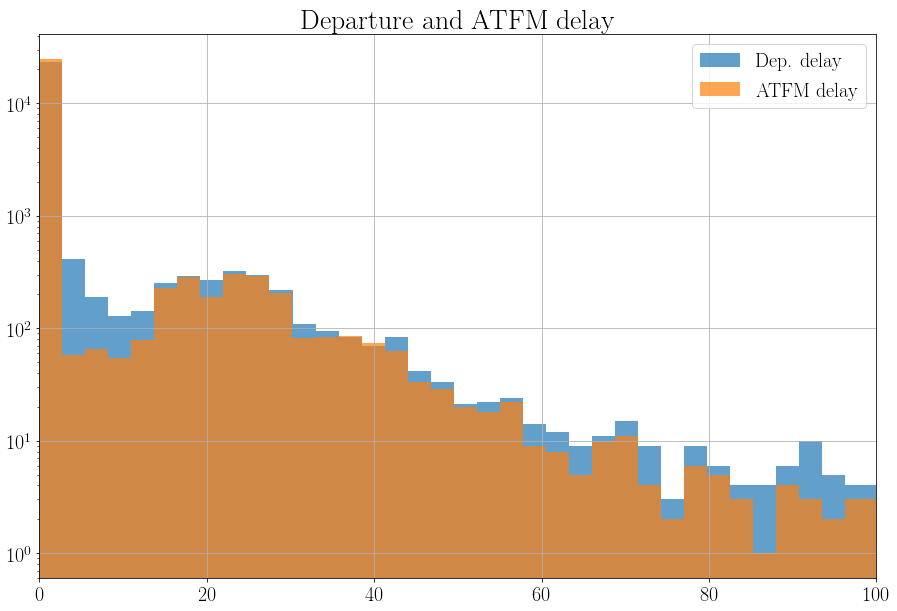

In [32]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Dep. delay')
df['atfm_delay'].hist(bins=500, ax=ax, alpha=0.7, label='ATFM delay')
ax.legend()
ax.set_title('Departure and ATFM delay')
ax.set_xlim((0, 100))
ax.set_yscale('log')

(-20, 100)

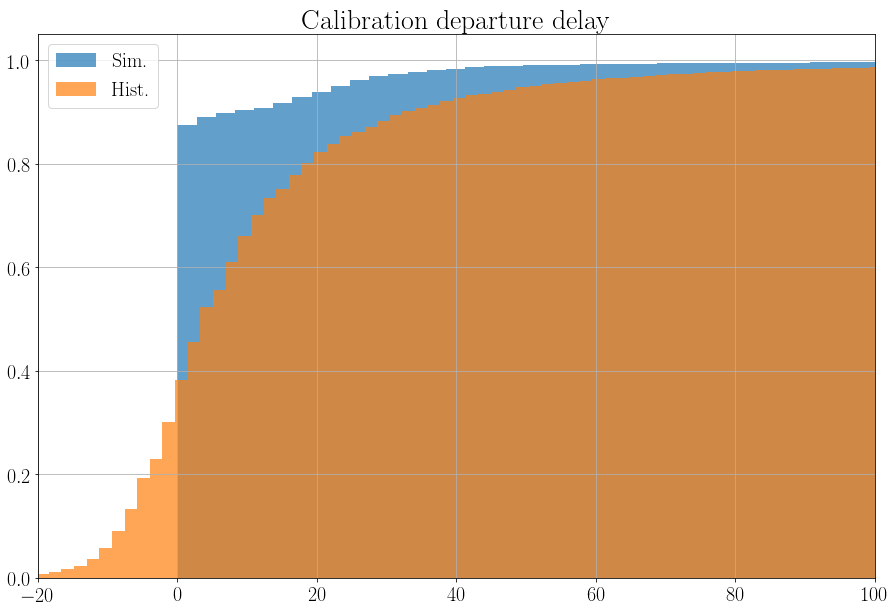

In [33]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.', cumulative=True, normed=True)
df_hist['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.', cumulative=True, normed=True)
ax.legend()
ax.set_title('Calibration departure delay')
ax.set_xlim((-20, 100))
#ax.set_yscale('log')

(-20, 100)

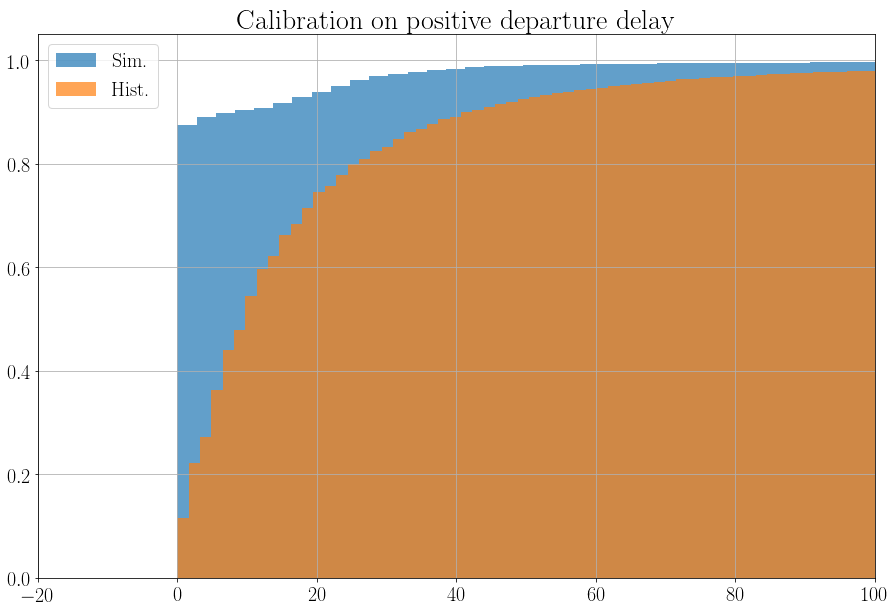

In [34]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.', cumulative=True, normed=True)
df_hist[df_hist['departure_delay']>=0.]['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.', cumulative=True, normed=True)
ax.legend()
ax.set_title('Calibration on positive departure delay')
ax.set_xlim((-20, 100))
#ax.set_yscale('log')

In [39]:
# # departure delay per type of delay
# options = {'bins':100, 'cumulative':True, 'alpha':0.7, 'normed':True}
# fig, axes = subplots(3, 2, figsize=(15, 15))
# df[df['main_reason_delay']=='RD']['departure_delay'].hist(ax=axes[0][0], label='Sim.', **options)
# df[df['main_reason_delay']=='TA']['departure_delay'].hist(ax=axes[0][1], label='Sim.', **options)
# df[df['main_reason_delay']=='ER']['departure_delay'].hist(ax=axes[1][0], label='Sim.', **options)
# df[df['main_reason_delay']=='C']['departure_delay'].hist(ax=axes[1][1], label='Sim.', **options)
# df[df['main_reason_delay']=='W']['departure_delay'].hist(ax=axes[2][0], label='Sim.', **options)

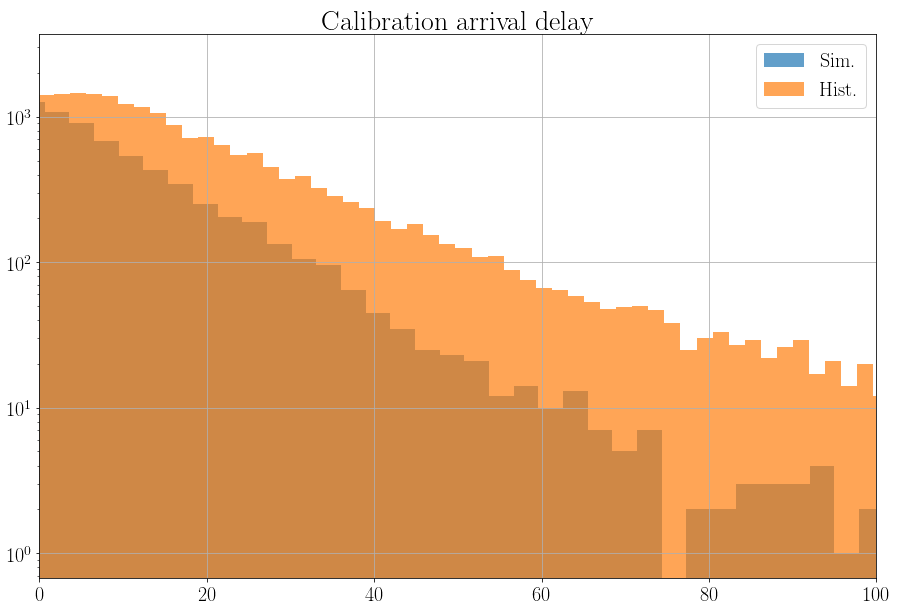

In [144]:
fig, ax = subplots(figsize=(15, 10))
df['arrival_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.')
df_hist['arrival_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.')
ax.legend()
ax.set_title('Calibration arrival delay')
ax.set_xlim((0, 100))
ax.set_yscale('log')

Text(0.5,1,'Calibration actual G2G time')

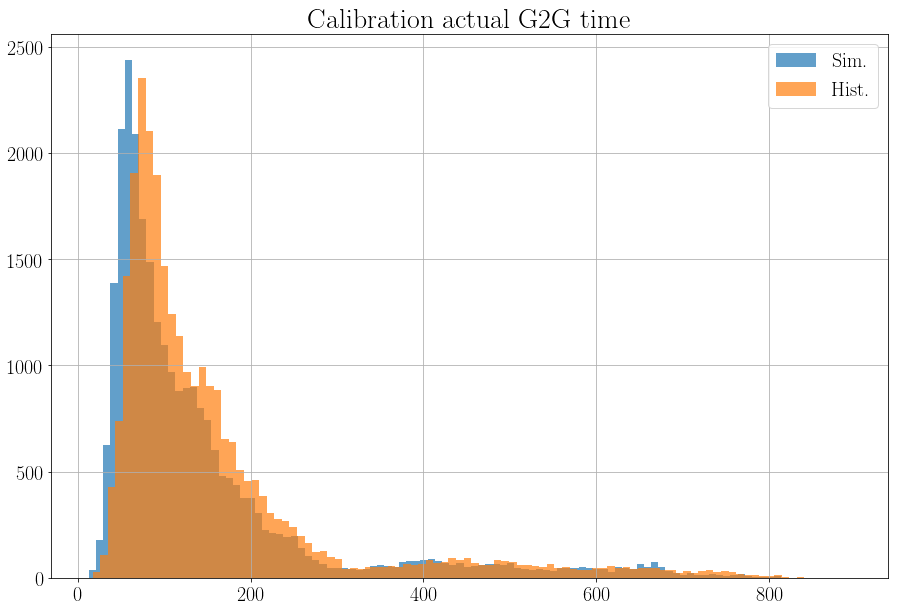

In [148]:
fig, ax = subplots(figsize=(15, 10))
df['actual_G2G_time'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.')
df_hist['actual_G2G_time'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.')
ax.legend()
ax.set_title('Calibration actual G2G time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Calibration actual flying time')

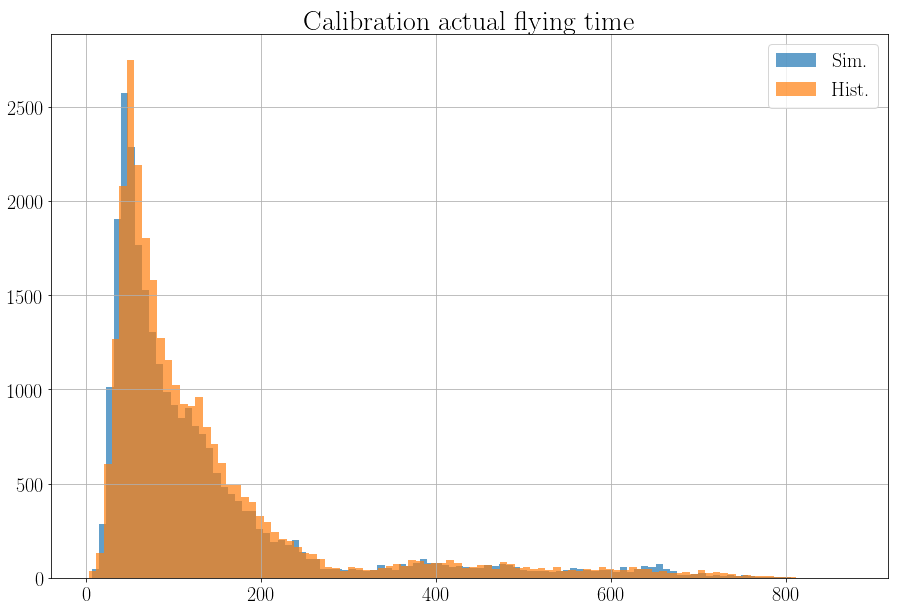

In [149]:
fig, ax = subplots(figsize=(15, 10))
df['actual_flying_time'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.')
df_hist['actual_flying_time'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.')
ax.legend()
ax.set_title('Calibration actual flying time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Calibration diff travelling time')

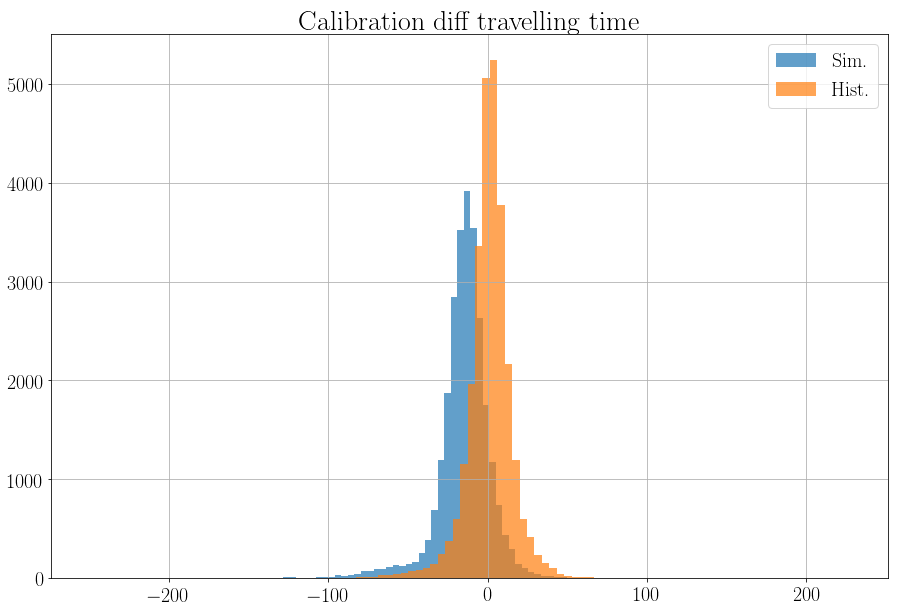

In [150]:
fig, ax = subplots(figsize=(15, 10))
df['travelling_time_diff'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.')
df_hist['travelling_time_diff'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.')
ax.legend()
ax.set_title('Calibration diff travelling time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Types of ATFM reasons')

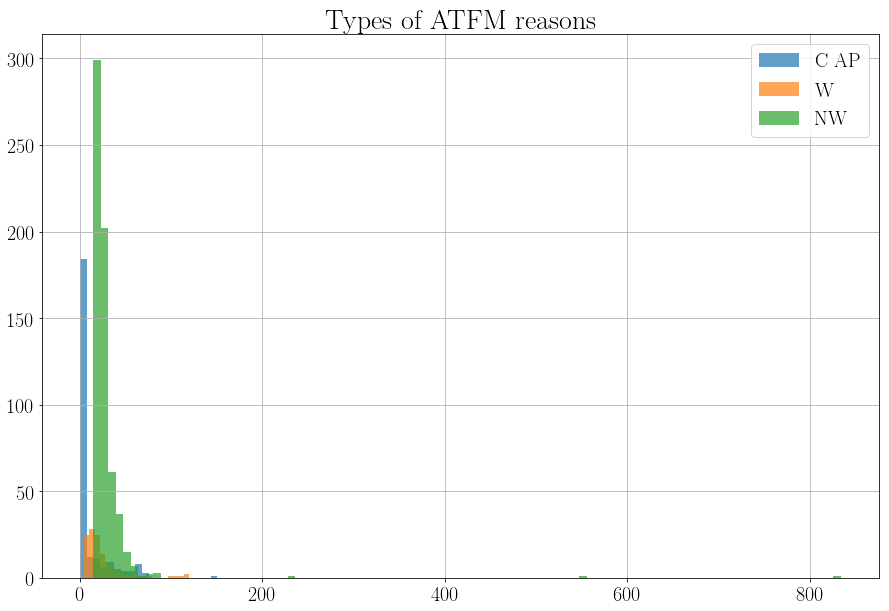

In [64]:
fig, ax = subplots(figsize=(15, 10))
mask = df['atfm_reason']=='C_AP'
df[mask]['atfm_delay'].hist(bins=20, ax=ax, alpha=0.7, label='C AP')
mask = df['atfm_reason']=='W'
df[mask]['atfm_delay'].hist(bins=20, ax=ax, alpha=0.7, label='W')
mask = df['atfm_reason']=='NW'
df[mask]['atfm_delay'].hist(bins=100, ax=ax, alpha=0.7, label='NW')
ax.legend()
ax.set_title('Types of ATFM reasons')
#ax = df['flight_time_diff'].hist(bins=500, figsize=(10, 7), label='Hist.')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')